In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from src.data.rgbd import load_rgbd
from src.data.pcd import load_pcd
from src.features.cropping import mask_selection_volume, box_mask_from_rgbd
from src.features.voxels import voxel2np

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

o3d.visualization.webrtc_server.enable_webrtc()

[Open3D INFO] WebRTC GUI backend enabled.


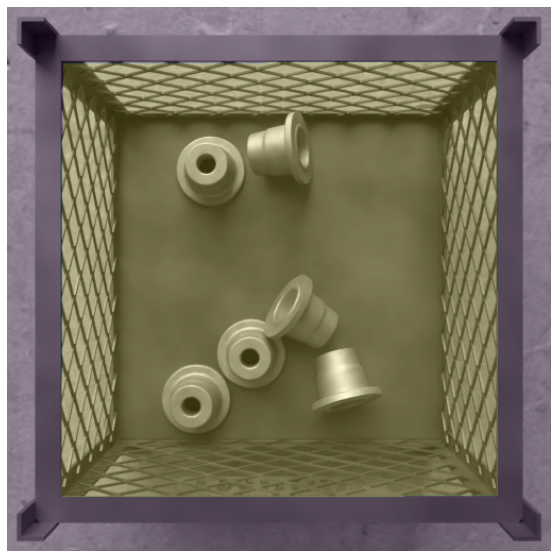

In [4]:
raw_data_dir = project_dir/'data/raw/render_results_imov_cam_mist_simple'

img_fpath = np.random.choice(list(raw_data_dir.glob('*/*.exr')))

rgbd = load_rgbd(img_fpath)

box_mask = box_mask_from_rgbd(rgbd)

plt.imshow(rgbd.color, cmap='gray')
plt.imshow(box_mask, alpha=0.2)
plt.gcf().set_size_inches(10,10)
plt.gca().set_axis_off()
plt.show()

In [5]:
vol = mask_selection_volume(rgbd, box_mask)

pcd = load_pcd(rgbd)

box = vol.crop_point_cloud(pcd)

box

PointCloud with 77712 points.

In [6]:
part_fpath = project_dir/'data/raw/part.stl'

part_mesh = o3d.io.read_triangle_mesh(str(part_fpath), enable_post_processing=True)

part_mesh.paint_uniform_color([1., 0., 0.,])

part = part_mesh.sample_points_uniformly(number_of_points=10000)

part_points = np.array(part.points) / 1000  # mm to meter conversion
part_points = part_points + np.array([0,0,0.3])
part_points = o3d.utility.Vector3dVector(part_points)
part.points = part_points

part

PointCloud with 10000 points.

In [6]:
o3d.visualization.draw([box, part])

[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: {"stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"}
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC HTTP server handshake mode enabled.
[Open3D INFO] Open3D WebVisualizer is serving at http://150.162.14.54:8889.
[Open3D INFO] Set WEBRTC_IP and WEBRTC_PORT environment variable to customize the HTTP server address.
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call


[000:000][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.411855904280342
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.411855904280342
[Open3D INFO] Sending init frames to window_0.


KeyboardInterrupt: 

# Reward

For a maximization problem.

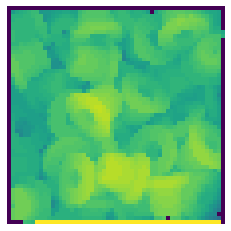

In [7]:
voxel_size = 0.01

box_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(box, voxel_size)
part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part, voxel_size)

# get grid shape and position
grid_pos = box_voxel.get_min_bound()
grid_pos[-1] = 0.0  # floor

grid_shape = (box_voxel.get_max_bound() - grid_pos) / box_voxel.voxel_size
grid_shape = (grid_shape + 0.5).astype(int)

box_grid = voxel2np(box_voxel, grid_pos, grid_shape)
part_grid = voxel2np(part_voxel, grid_pos, grid_shape, mode='floating')

plt.imshow((part_grid | box_grid).sum(axis=-1))
plt.gca().set_axis_off()
plt.show()

## Intersection of the part with the box

To motivate its insertion inside the volume captured.

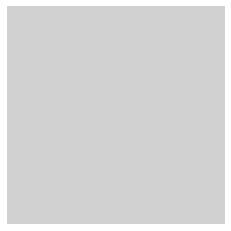

In [10]:
%matplotlib inline

# plt.imshow(box_grid.sum(axis=-1), cmap='gray')
plt.imshow((part_grid & box_grid).sum(axis=-1), cmap='Accent_r', alpha=0.3)

plt.gca().set_axis_off()
plt.show()

In [12]:
%matplotlib widget

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(box_grid, facecolors='gray')
ax.voxels(part_grid, facecolors='red')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [8]:
def intersection_value(box_grid, part_grid):
    return (box_grid & part_grid).sum()

intersection_value(box_grid, part_grid)

744

As the part was created filling everything below it, this rewards more the parts positioned higher.

## Cumulative surface distance

To motivate the solution closest to the surface of the box image.

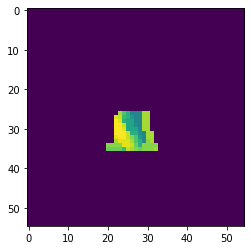

In [27]:
%matplotlib inline

part_surface = (np.indices(part_grid.shape)[-1] * part_grid).max(axis=-1)
part_mask = part_grid.sum(axis=-1) > 0

box_surface = (np.indices(box_grid.shape)[-1] * box_grid).max(axis=-1)

plt.imshow(box_surface * part_mask)

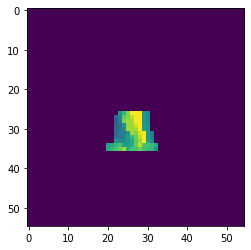

In [29]:
plt.imshow(np.abs((box_surface * part_mask) - part_surface))

In [9]:
def surface_distance(box_grid, part_grid):
    part_surface = (np.indices(part_grid.shape)[-1] * part_grid).max(axis=-1)
    part_mask = part_grid.sum(axis=-1) > 0

    box_surface = (np.indices(box_grid.shape)[-1] * box_grid).max(axis=-1)
    
    distances = np.abs((box_surface * part_mask) - part_surface)
    
    return distances.sum()

surface_distance(box_grid, part_grid)

819

## Final reward

In [10]:
def reward(box_grid, part_grid):
    return intersection_value(box_grid, part_grid) \
           - surface_distance(box_grid, part_grid)

reward(box_grid, part_grid)

-75

In [49]:
%matplotlib widget

new_part = o3d.geometry.PointCloud(part)

new_part.translate(np.array([0.25,0,0]))

new_part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(new_part, voxel_size)
new_part_grid = voxel2np(new_part_voxel, grid_pos, grid_shape, mode='floating')

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(box_grid, facecolors='gray')
ax.voxels(new_part_grid, facecolors='red')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [41]:
reward(box_grid, new_part_grid)

108

# Objective function

In [26]:
class _PointCloudTransmissionFormat:  # see https://github.com/isl-org/Open3D/issues/218
    def __init__(self, pointcloud: o3d.geometry.PointCloud):
        self.points = np.array(pointcloud.points)
        self.colors = np.array(pointcloud.colors)
        self.normals = np.array(pointcloud.normals)

    def create_pointcloud(self) -> o3d.geometry.PointCloud:
        pointcloud = o3d.geometry.PointCloud()
        pointcloud.points = o3d.utility.Vector3dVector(self.points)
        pointcloud.colors = o3d.utility.Vector3dVector(self.colors)
        pointcloud.normals = o3d.utility.Vector3dVector(self.normals)
        return pointcloud

def eval_position(x, box_grid, part: _PointCloudTransmissionFormat, voxel_size, grid_pos, grid_shape):
    tx, ty, tz, rx, ry, rz = x

    part_ = part.create_pointcloud()

    part_.translate(np.array([tx, ty, tz]))

    part_.rotate(
        o3d.geometry.get_rotation_matrix_from_xyz(np.array([rx, ry, rz]))
    )

    part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part_, voxel_size)
    part_grid = voxel2np(part_voxel, grid_pos, grid_shape, mode='floating')

    return - reward(box_grid, part_grid)

eval_position([0., 0., -0.2, 0.05, 0., 0.1], box_grid, _PointCloudTransmissionFormat(part), voxel_size, grid_pos, grid_shape)

14949

# PSO

In [22]:
box_voxel.voxel_size

0.01

2022-03-01 21:44:02,434 - pyswarms.single.global_best - INFO - Optimize for 250 iters with {'c1': 0.5, 'c2': 0.0, 'w': 0.9}
pyswarms.single.global_best: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|250/250, best_cost=-302
2022-03-01 21:44:28,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -302.0, best pos: [-7.70143361e-04  6.11536371e-02 -9.46070102e-02 -1.78388818e+00
 -1.94152103e+00  1.00996346e+00]


CPU times: user 5.32 s, sys: 172 ms, total: 5.49 s
Wall time: 26 s


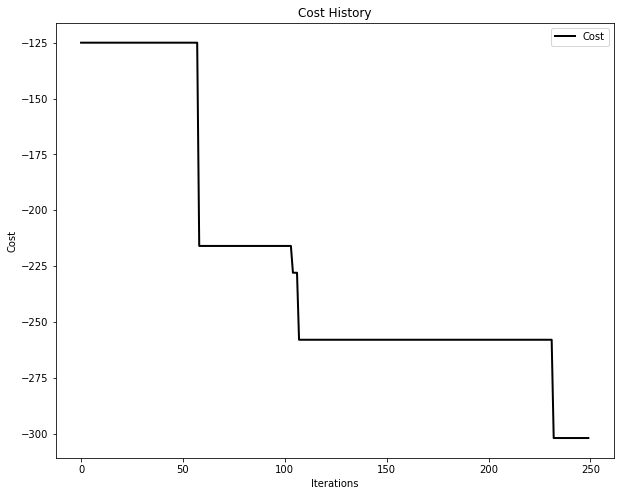

In [24]:
%matplotlib inline

import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history

from src.models.pso import eval_position, reward, _PointCloudTransmissionFormat

voxel_size = 0.01

box_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(box, voxel_size)

# get grid shape and position
grid_pos = box_voxel.get_min_bound()
grid_pos[-1] = 0.1288  # floor

grid_shape = (box_voxel.get_max_bound() - grid_pos) / box_voxel.voxel_size
grid_shape = (grid_shape + 0.5).astype(int)

box_grid = voxel2np(box_voxel, grid_pos, grid_shape)


min_bound = np.array([-0.5, -0.5, -0.5, -np.pi, -np.pi, -np.pi])
bounds = (min_bound, -min_bound)

optimizer = ps.single.GlobalBestPSO(
# optimizer = ps.single.LocalBestPSO(
    n_particles=18,
    dimensions=6,
    bounds=bounds,
    options={'c1': 0.5, 'c2': 0.0, 'w':0.9},
#     options={'c1': 0.5, 'c2': 0.0, 'w':0.9, 'k': 2, 'p': 2},
)

def objective_f(xs, box_grid, part, voxel_size, grid_pos, grid_shape):
#     print(xs)
    if xs.size > 0:
        return np.apply_along_axis(eval_position, -1, xs, box_grid=box_grid, part=part, voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)
    else:
        return np.apply_along_axis(eval_position, -1, np.array([0.,0.,0.,0.,0.,0.]), box_grid=box_grid, part=part, voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)
    
%time cost, pos = optimizer.optimize(objective_f, iters=250, n_processes=6, box_grid=box_grid, part=_PointCloudTransmissionFormat(part), voxel_size=voxel_size, grid_pos=grid_pos, grid_shape=grid_shape)

plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [30]:
%matplotlib widget

tx, ty, tz, rx, ry, rz = pos

part_ = o3d.geometry.PointCloud(part)

part_.translate(np.array([tx, ty, tz]))

part_.rotate(
    o3d.geometry.get_rotation_matrix_from_xyz(np.array([rx, ry, rz]))
)

part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part_, voxel_size)
part_grid = voxel2np(part_voxel, grid_pos, grid_shape, mode='floating')

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(box_grid, facecolors='gray')
ax.voxels(part_grid, facecolors='red')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [49]:
tx, ty, tz, rx, ry, rz = pos

part_ = o3d.geometry.PointCloud(part)

part_.translate(np.array([tx, ty, tz]))

part_.rotate(
    o3d.geometry.get_rotation_matrix_from_xyz(np.array([rx, ry, rz]))
)

o3d.visualization.draw([box, part_])

[Open3D INFO] Window window_11 created.
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.6636255717346637
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.6636255717346637
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.6636255717346637
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.6636255717346637
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] 

[7115:888][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[7115:954][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.7749537942166624
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.7749537942166624
[Open3D INFO] Sending init frames to window_11.


[7116:099][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[7116:192][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.6248131085718944
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.6248131085718944
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.6248131085718944
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.6248131085718944
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.3719839262876792
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.3719839262876792
[Open3D INFO] Sending init frames to window_8.


[7116:785][224064] (sctp_transport.cc:805): ERROR:SctpTransport->SendMessageInternal(...):  usrsctp_sendv:  : [0x00000002] No such file or directory
[7116:785][224060] (sctp_data_channel.cc:726): Closing the DataChannel due to a failure to send the CONTROL message, send_result = 1


[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.3719839262876792
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.3719839262876792
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.3719839262876792
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.3719839262876792


[7117:291][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[7117:310][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[7117:352][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[7117:355][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0
[7117:357][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate


[7117:772][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList


[7117:981][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/hangup


[7122:973][224064] (dtls_transport.cc:529): DtlsTransport[0|1|__]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.


[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Calle

[7133:229][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3

[7162:221][224064] (stun_port.cc:96): Binding request timed out from 150.162.14.x:56733 (enp5s0)


[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.7749537942166624
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.7749537942166624
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closing, peerid: 0.7749537942166624
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: closed, peerid: 0.7749537942166624
[Open3D INFO] [Called HTTP API] /api/hangup


[7187:534][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.6377162987595468
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.6377162987595468
[Open3D INFO] Sending init frames to window_0.
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/getIceServers
[Open3D INFO] [Called HTTP API] /api/call
[Open3D INFO] [Called HTTP API] /api/hangup
[Open3D INFO] [Called HTTP API] /api/getMediaList
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closing, peerid: 0.6377162987595468
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: closed, peerid: 0.6377162987595468
[Open3D INFO] DataChannelObserver::OnSt

[7188:850][224060] (webrtc_video_engine.cc:3394): Absent receive stream; ignoring clearing encoded frame sink for ssrc 0


[Open3D INFO] [Called HTTP API] /api/getIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ServerDataChannel, state: open, peerid: 0.21005815647906045
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] [Called HTTP API] /api/addIceCandidate
[Open3D INFO] DataChannelObserver::OnStateChange label: ClientDataChannel, state: open, peerid: 0.21005815647906045
[Open3D INFO] Sending init frames to window_11.


KeyboardInterrupt: 

# Dig part from box

In [25]:
tx, ty, tz, rx, ry, rz = pos

part_ = o3d.geometry.PointCloud(part)

part_.translate(np.array([tx, ty, tz]))

part_.rotate(
    o3d.geometry.get_rotation_matrix_from_xyz(np.array([rx, ry, rz]))
)

part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part_, voxel_size)

In [28]:
%matplotlib widget

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(box_grid, facecolors='gray')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
%matplotlib widget

part_grid = voxel2np(part_voxel, grid_pos, grid_shape, mode='floating')

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(box_grid, facecolors='gray')
ax.voxels(part_grid, facecolors='red')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [27]:
%matplotlib widget

part_grid = voxel2np(part_voxel, grid_pos, grid_shape, mode='reverse-shadow')

digged_box_grid = box_grid & ~(box_grid & part_grid)

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(digged_box_grid, facecolors='gray')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …